In [1]:
import pandas as pd

In [2]:
from libraries.client_stashapp import get_stashapp_client

stash = get_stashapp_client()

videos_paths = ["/videos_x", "/videos_y", "/videos_z", "/videos_f"]

d Using stash (v0.25.1-0) endpoint at http://fraktal.auvilankuja.fi:9999/graphql


In [53]:
stash.metadata_scan(videos_paths, {
    "scanGenerateClipPreviews": False,
    "scanGenerateCovers": True,
    "scanGenerateImagePreviews": False,
    "scanGeneratePhashes": True,
    "scanGeneratePreviews": False,
    "scanGenerateSprites": False,
    "scanGenerateThumbnails": False
})

'61'

In [54]:
def get_parent_studio_id(studio):
    if studio["parent_studio"] is not None:
        return studio["parent_studio"]["id"]
    return None

studios = stash.find_studios({})
df_studios = pd.DataFrame(studios)
df_studios["parent_studio_id"] = df_studios.apply(get_parent_studio_id, axis=1)

In [55]:
performers = stash.find_performers({})
df_performers = pd.DataFrame(performers)


In [56]:
# Lookup functions
def get_by_parent_studio(parent_studio_id):
    return df_studios[df_studios["parent_studio_id"] == parent_studio_id]

def get_studio(studio_id):
    return df_studios[df_studios["id"] == studio_id]

def get_performer(performer_id):
    return df_performers[df_performers["id"] == performer_id]

In [57]:
current_studios = get_by_parent_studio("505")
# current_studios = get_studio("79")
current_studio_ids = current_studios["id"].to_list()

current_studios

,id,name,url,parent_studio,child_studios,aliases,ignore_auto_tag,image_path,scene_count,image_count,gallery_count,performer_count,movie_count,stash_ids,rating100,details,created_at,updated_at,movies,parent_studio_id
3,53,3rd Degree,https://www.3rddegreefilms.com/,{'id': '505'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/53/i...,8,0,0,8,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-28T18:15:48Z,2024-04-21T11:17:36Z,[],505
109,506,BiPhoria,https://www.biphoria.com/en,{'id': '505'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/506/...,4,0,0,10,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-02-09T03:59:47Z,2024-04-21T11:18:48Z,[],505
215,793,Diabolic,https://www.diabolic.com/,{'id': '505'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/793/...,3,0,0,6,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-03-01T02:32:57Z,2024-04-21T11:19:32Z,[],505
908,521,ZTOD,,{'id': '505'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/521/...,1,0,0,6,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2024-02-09T04:17:57Z,2024-04-21T11:18:50Z,[],505


In [65]:
# Find scenes with specific title
# scenes_data = stash.find_scenes({ "title": { "value": "sucker", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
# scenes_data = stash.find_scenes({ "performers": { "value": ["210"], "excludes": [], "modifier": "INCLUDES_ALL" } }, filter={ "per_page": 120, "page": 6, "sort": "path", "direction": "DESC" })
scenes_data = stash.find_scenes({
    # "studios": { "value": current_studio_ids, "excludes": [], "modifier": "INCLUDES" },
    # "stash_id_endpoint": { "endpoint": "", "stash_id": "", "modifier": "NOT_NULL" },
    "studios": { "value": [], "excludes": [], "modifier": "NOT_NULL" },
    "performers": { "value": [], "excludes": [], "modifier": "NOT_NULL" }
}, filter={ "per_page": 500, "page": 8, "sort": "created_at", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)
print(len(scenes_df))

500


In [66]:
def get_path(files):
    return files[0]["path"] if files else None

def get_basename(files):
    return files[0]["basename"] if files else None

def get_first_file_resolution(files):
    return str(files[0]["width"]) + "x" + str(files[0]["height"]) if files else None

def get_studio_value(studio):
    if (studio is None):
        return "Unknown Studio"

    stash_studio = get_studio(studio["id"])
    if stash_studio.empty:
        return "Unknown Studio"
    
    parent_stash_studio = get_studio(stash_studio["parent_studio_id"].iloc[0])
    if not parent_stash_studio.empty:
        return parent_stash_studio["name"].iloc[0] + "꞉ " + stash_studio["name"].iloc[0]

    return stash_studio["name"].iloc[0]

def get_performers(performers):
    return _get_performers(performers)

def get_non_male_performers(performers):
    return _get_performers(performers, 3)

def _get_performers(performers, exclude_gender = None):
    if len(performers) == 0:
        return "Unknown performers"

    stash_performers = []
    for performer in performers:
        stash_performer = get_performer(performer["id"])
        if not stash_performer.empty:
            stash_performers.append(stash_performer)
        else:
            raise Exception("Performer not found with ID: " + performer["id"])
    
    # Concatenate the data frames into a single data frame
    df_stash_performers = pd.concat(stash_performers)

    # Sort by gender with a custom order and then by name
    # Define a custom sort order for gender
    gender_priority = {
        'TRANSGENDER_FEMALE': 1,
        'FEMALE': 2,
        'MALE': 3
    }
    
    # Map the 'gender' column to these priorities
    df_stash_performers['gender_priority'] = df_stash_performers['gender'].map(gender_priority).fillna(4)  # Any undefined genders get a default value

    # Now sort by this priority, and then by name
    
    df_stash_performers.sort_values(by=['gender_priority', 'name'], inplace=True)
    
    if exclude_gender is not None:
        result = ', '.join(df_stash_performers[df_stash_performers['gender_priority'] != exclude_gender]['name'])
    else:
        result = ', '.join(df_stash_performers['name'])

    # Cleanup: remove the auxiliary 'gender_priority' column if no longer needed
    df_stash_performers.drop('gender_priority', axis=1, inplace=True)

    return result

# Define a function to get the first file if available
def get_suffix(files):
    first_file = files[0]["basename"] if files else None
    file_suffix = os.path.splitext(first_file)[1] if first_file else None
    return file_suffix

def title_case_except_acronyms(text):
    words = text.split()
    title_cased_words = []
    for word in words:
        # Check if the word contains an apostrophe
        if "'" in word:
            # Split the word at the apostrophe and process each part
            parts = word.split("'")
            new_parts = [parts[0].title()]  # Always capitalize the part before the apostrophe
            if len(parts) > 1:
                # Never capitalize after the apostrophe
                new_parts.append(parts[1])
            # Rejoin the parts with an apostrophe
            title_cased_words.append("'".join(new_parts))
        else:
            # Apply the original logic if there's no apostrophe
            title_cased_words.append(word if word.isupper() and len(word) > 1 else word.title())

    return ' '.join(title_cased_words)

def clean_title(title):
    title = title_case_except_acronyms(title)
    return title.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

import os
import re

def convert_stash_path_to_windows_path(files):
    # Check if files is not empty and contains a dictionary with a "path" key
    if not files or "path" not in files[0]:
        return None
    
    path = files[0]["path"]
    if path:
        # Try to extract the drive letter from the path using a regex
        match = re.search(r'/videos_(\w)/', path)
        if match:
            drive_letter = match.group(1).upper()
            # Replace '/videos_x/' with 'X:\' using the drive letter extracted
            path = re.sub(r'/videos_\w/', drive_letter + ':\\\\Culture\\\\Videos\\\\', path)
            # Normalize the path to use backslashes instead of forward slashes
            path = os.path.normpath(path)
        else:
            return None  # Return None if no matching pattern is found
    return path

# Apply the function to the 'files' column
scenes_df['path'] = scenes_df['files'].apply(get_basename)
scenes_df['windows_path'] = scenes_df['files'].apply(convert_stash_path_to_windows_path)
scenes_df['windows_directory'] = scenes_df['files'].apply(lambda files: os.path.dirname(convert_stash_path_to_windows_path(files)))
scenes_df['basename'] = scenes_df['files'].apply(get_basename)
scenes_df['resolution'] = scenes_df['files'].apply(get_first_file_resolution)
scenes_df['primary_studio'] = scenes_df['studio'].apply(get_studio_value)
scenes_df['performers_str'] = scenes_df['performers'].apply(get_performers)
scenes_df['non_male_performers_str'] = scenes_df['performers'].apply(get_non_male_performers)
scenes_df['suffix'] = scenes_df['files'].apply(get_suffix)


In [67]:
import pandas as pd
import requests

# First check that windows_path is not null for all rows as that is used for mapping
scenes_df['windows_path'].notnull().all()

# Request all Laputin files
url = f"http://localhost:33333/api/files?status=both"
response = requests.get(url)
laputin_files = response.json()
df_laputin_files = pd.DataFrame(laputin_files)
df_laputin_files['xxhash'] = df_laputin_files['metadata'].apply(
    lambda x: x.get('hashes', {}).get('xxhash') if x else None
)
df_laputin_files = df_laputin_files.drop_duplicates(subset="path")

# Map xxhash to scenes_df
scenes_df["xxhash"] = scenes_df["windows_path"].map(df_laputin_files.set_index("path")["xxhash"])

In [68]:
MAX_LENGTH = 255

# Assuming scenes_df and the function clean_title are defined
scenes_df['fs_title'] = scenes_df['title'].apply(clean_title)

def clean_filename(filename):
    filename = title_case_except_acronyms(filename)
    return filename.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

def create_filename(row, with_studio_code):
    xxhash = row['xxhash']
    xxhash_fmt = " [" + str(xxhash) + "]"

    suffix_length = len(row['suffix']) if row['suffix'] else 0
    xxhash_length = len(xxhash_fmt)
    max_length_wo_xxhash_suffix = MAX_LENGTH - xxhash_length - suffix_length

    # Choose between full performers string or a limited one based on the current combination length
    performers_str = row['performers_str']
    base_filename = f"{row['primary_studio']} – {row['date']} – "
    
    if with_studio_code:
        base_filename += clean_filename(f"{row['code']} – ")
    
    base_filename += clean_filename(f"{row['fs_title']} – {performers_str}")

    # Check if the generated filename exceeds the maximum length
    if len(base_filename) + len(row['suffix']) > max_length_wo_xxhash_suffix:
        # Use non_male_performers_str if the full string is too long
        performers_str = row['non_male_performers_str']
        base_filename = f"{row['primary_studio']} – {row['date']} – "
        
        if with_studio_code:
            base_filename += clean_filename(f"{row['code']} – ")
        
        base_filename += clean_filename(f"{row['fs_title']} – {performers_str}")

    return base_filename + xxhash_fmt + row['suffix']

# Apply the function to create new filenames
scenes_df['new_filename'] = scenes_df.apply(create_filename, with_studio_code=False, axis=1)

scenes_df['new_path'] = scenes_df['windows_directory'] + '\\' + scenes_df['new_filename']
scenes_df['new_path'] = scenes_df['new_path'].apply(lambda x: os.path.normpath(x))
scenes_df['windows_path'] = scenes_df['windows_path'].apply(lambda x: os.path.normpath(x))

renames_df = scenes_df
renames_df = renames_df.loc[renames_df['xxhash'].notnull()]
renames_df = renames_df.loc[renames_df['new_path'].notnull()]
renames_df = renames_df.loc[renames_df['windows_path'] != renames_df['new_path']]
renames_df = renames_df[['windows_path', 'new_path', 'xxhash']]
renames_df = renames_df.sort_values(by='windows_path')
renames_df['new_path'].to_list()

["X:\\Culture\\Videos\\Good Old In And Out\\Evil Angel – 2017-11-30 – – Cheating Whore's Behavior – Melissa Moore, Zoe Parker, Alex D [d824e25d93f5bd52].mp4",
 'X:\\Culture\\Videos\\Is This Real Life\\Virtual Taboo꞉ Dark Room VR – 2022-12-02 – – Wedding Gift – Ann Joy, Sky Pierce [319a65ca32d4d5b1].mp4',
 'X:\\Culture\\Videos\\Is This Real Life\\Naughty America (Network)꞉ Naughty Athletics – 2022-04-12 – – Petite Babes, Melissa Moore & Riley Reid, Are Taking Tennis Lessons But Would Rather Go Back To Your Place And Play With Your Balls – Melissa Moore, Riley Reid [abf17a35e541a72b].mp4',
 'X:\\Culture\\Videos\\Is This Real Life\\Sexbabesvr – 2023-10-16 – 38347 – We Become One – Veronica Leal [9fd49001d9d5e29e].mp4',
 'X:\\Culture\\Videos\\Is This Real Life\\Virtual Taboo – 2023-06-02 – – Pussy Score – Ann Joy, Simona Purr [7380e83a62864d10].mp4',
 'X:\\Culture\\Videos\\Sites\\Amateur Allure\\Amateur Allure – 2016-12-02 – – Melissa Moore POV, Busty Teen Beauty Swallows Cum In 4K Video –

In [69]:
import os
import pandas as pd

# Assuming renames_df is already defined and has columns 'windows_path', 'new_path', 'xxhash'

# Initialize empty DataFrames for success and failure results
success_df = pd.DataFrame(columns=renames_df.columns)
failed_df = pd.DataFrame(columns=renames_df.columns)

for index, row in renames_df.iterrows():
    old_path = row['windows_path']
    new_path = row['new_path']
    print(f"Processing {old_path} to {new_path}")

    # Check for missing hash or new path
    if pd.isna(row['xxhash']):
        print(f"XXHash not found for {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        continue
    if pd.isna(new_path):
        print(f"New path not found for {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        continue

    # Attempt to move the file if the old path is a file and the new path does not exist
    if os.path.isfile(old_path):
        if not os.path.exists(new_path):
            try:
                identical = old_path == new_path

                os.rename(old_path, new_path)
                print(f"Rename file:\n{old_path}\n{new_path}")
                success_df = pd.concat([success_df, pd.DataFrame([row])], ignore_index=True)
            except Exception as e:
                print(f"Failed to rename:\n{old_path}\n{new_path}\n{e}")
                failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
        else:
            print(f"A file already exists in the new path: {new_path}")
            failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)
    else:
        print(f"File does not exist: {old_path}")
        failed_df = pd.concat([failed_df, pd.DataFrame([row])], ignore_index=True)

len(renames_df) == len(success_df)


Processing X:\Culture\Videos\Good Old In And Out\blackmailed.17.12.01.melissa.moore.cheating.whores.blackmailed.behavior.4k.mp4 to X:\Culture\Videos\Good Old In And Out\Evil Angel – 2017-11-30 – – Cheating Whore's Behavior – Melissa Moore, Zoe Parker, Alex D [d824e25d93f5bd52].mp4
Rename file:
X:\Culture\Videos\Good Old In And Out\blackmailed.17.12.01.melissa.moore.cheating.whores.blackmailed.behavior.4k.mp4
X:\Culture\Videos\Good Old In And Out\Evil Angel – 2017-11-30 – – Cheating Whore's Behavior – Melissa Moore, Zoe Parker, Alex D [d824e25d93f5bd52].mp4
Processing X:\Culture\Videos\Is This Real Life\DarkRoomVR.Wedding.Gift.Ann.Joy,.Sky.Pierce.Oculus.7K..3630p.mp4 to X:\Culture\Videos\Is This Real Life\Virtual Taboo꞉ Dark Room VR – 2022-12-02 – – Wedding Gift – Ann Joy, Sky Pierce [319a65ca32d4d5b1].mp4
Rename file:
X:\Culture\Videos\Is This Real Life\DarkRoomVR.Wedding.Gift.Ann.Joy,.Sky.Pierce.Oculus.7K..3630p.mp4
X:\Culture\Videos\Is This Real Life\Virtual Taboo꞉ Dark Room VR – 202

False

In [ ]:
success_df

,windows_path,new_path,xxhash
0,Y:\Culture\Videos\Sites\Vixen Media Group\Tush...,Y:\Culture\Videos\Sites\Vixen Media Group\Tush...,da6ae6b47b51b95b
1,Y:\Culture\Videos\Spermmania.Alexis.Crystal.Us...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,fd1c27a4c08c176d
2,Y:\Culture\Videos\Spermmania.Alexis.Crystals.P...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,bf23a109d5093cd1
3,Y:\Culture\Videos\alexis crystal spermmania-22...,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,cc603649c4b555b4
4,Y:\Culture\Videos\spermmania-217.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,83c1d1ae6a48fcb8
5,Y:\Culture\Videos\spermmania-220.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,5088a75d3c52681c
6,Y:\Culture\Videos\spermmania-223.mp4,Y:\Culture\Videos\Digital J Media꞉ Sperm Mania...,0f55b47d5eafeb27
7,Z:\Culture\Videos\CHECKED\279-czechvr-3d-2880x...,Z:\Culture\Videos\CHECKED\Czech VR Network꞉ Cz...,e7dc1af85a1e4699
8,Z:\Culture\Videos\CHECKED\Alexis Crystal SZ173...,Z:\Culture\Videos\CHECKED\Anal Vids꞉ Gonzo – 2...,d6b0201da51da481
9,Z:\Culture\Videos\CHECKED\AlexisCrystalCollect...,Z:\Culture\Videos\CHECKED\1 Pass for All Sites...,e0be33116af809d4


In [49]:
failed_df

,windows_path,new_path,xxhash
0,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,16afcdc0b40e0f1b
1,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,d19899a33a5b7ce5
2,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,c5e12ecd508a2a47
3,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,0bf2fa91867f5f0e
4,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,8d14bdaf5b3f6621
5,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,35ae767a2db557c2
6,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,6ebbe9db8ac988cf
7,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,d43611f9a7d913b7
8,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,1ee741d90ed65d42
9,X:\Culture\Videos\Sites\Reality Kings\Reality ...,X:\Culture\Videos\Sites\Reality Kings\Reality ...,66b49c56e0887538


In [51]:
import difflib

# Assuming failed_renames_df and failed_df are defined
failed_renames_df = renames_df[renames_df['xxhash'].isin(failed_df['xxhash'])].copy()

def format_diff(old, new):
    diff = list(difflib.ndiff(old, new))
    formatted_diff = ''.join(diff)
    return formatted_diff

failed_renames_df['diff'] = failed_renames_df.apply(lambda row: format_diff(row['windows_path'], row['new_path']), axis=1)


Non-renaming things start from here.

In [46]:
# Find female performers
female_performers = stash.find_performers({ "gender": { "value": "FEMALE", "modifier": "EQUALS" } })
df_female_performers = pd.DataFrame(female_performers)
df_female_performers['birthdate'] = pd.to_datetime(df_female_performers['birthdate'])

In [47]:
favorite_performers = stash.find_performers({ "filter_favorites": True })
df_favorite_performers = pd.DataFrame(favorite_performers)
df_favorite_performers['birthdate'] = pd.to_datetime(df_favorite_performers['birthdate'])

In [48]:
from IPython.display import Image
from IPython.display import display

# Assuming df is your DataFrame and 'image_path' is your column with URLs
x = Image(url= df_favorite_performers['image_path'][0]) 
display(x)

In [33]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.2 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.2 kB ? eta -:--:--
     -------------- ------------------------ 61.4/162.2 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 162.2/162.2 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.9/7.6 MB 29.7 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.6 MB 37.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 40.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.6 MB 36.7 MB/s eta 0:00:01
   ---------------------------------- ----- 6.7/7.6 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.7 kB ? eta -:--:--
   -----------

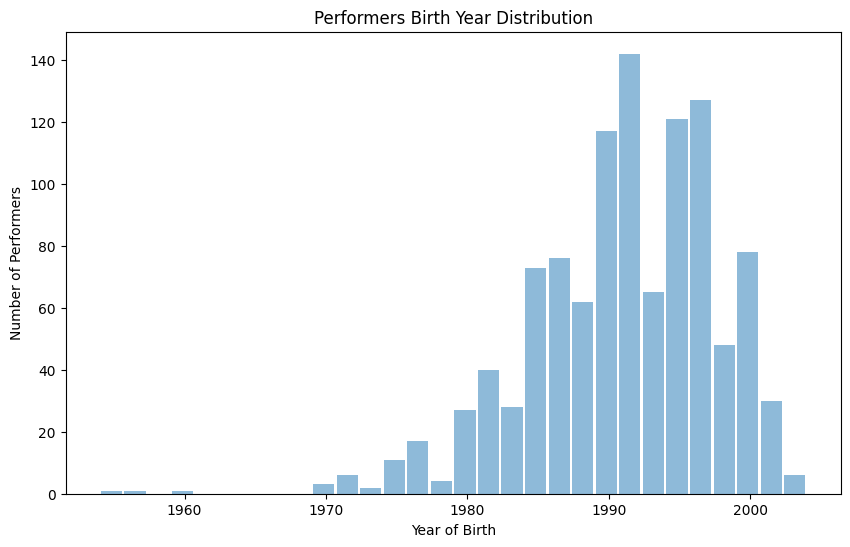

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_female_performers['birthdate'].dt.year.hist(bins=30, alpha=0.5, rwidth=0.9)
plt.xlabel('Year of Birth')
plt.ylabel('Number of Performers')
plt.title('Performers Birth Year Distribution')
plt.grid(False)
plt.show()

In [ ]:
# Find scenes with specific performer
scenes_data = stash.find_scenes({ "title": { "value": "erections", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)